In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
RESPONSE_VARS = df.columns[-1]

print(f'Input variables: {INPUT_VARS.values}'
      f'\nResponse variable: {RESPONSE_VARS}')
print(f'Shape of the dataframe: {df.shape}')

# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float=0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds

# Create train/test sets
df.sort_values(by='prod', ascending=False, inplace=True)
test = df[:10].copy()
train = df[10:].copy()

X_train = train.drop('prod', axis=1)
y_train = train['prod'].values.ravel()

X_test = test.drop('prod', axis=1)
y_test = test['prod'].values.ravel()

bounds = get_bounds(train, INPUT_VARS)
display(bounds)

Input variables: ['ERG8' 'ERG10' 'ERG12' 'ERG13' 'ERG19' 'ERG20' 'IDI1' 'tHMG1']
Response variable: prod
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1
min,0,0,0,0,0,0,0,0
max,21.70044,21.762191,25.856475,23.314336,21.509215,22.215345,5.881847,12.536361


In [4]:
def objective(trial):
    C = trial.suggest_float('C', 0.001, 100)
    epsilon = trial.suggest_float('epsilon', 0.01, 1)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    model = SVR(C=C, epsilon=epsilon, gamma=gamma)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, show_progress_bar=True)
best_params = study.best_params
best_score = study.best_value
final_model = SVR(C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])
final_model.fit(X_train, y_train)

[I 2024-02-01 21:31:29,180] A new study created in memory with name: no-name-eee21802-cd0f-4a68-ba37-41b4f3ee72b3


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2024-02-01 21:31:29,229] Trial 0 finished with value: -26.24780632593999 and parameters: {'C': 57.19855144375702, 'epsilon': 0.17794193216110432, 'gamma': 0.025121011334036096}. Best is trial 0 with value: -26.24780632593999.
[I 2024-02-01 21:31:29,263] Trial 1 finished with value: -25.745027470639315 and parameters: {'C': 85.47966220698129, 'epsilon': 0.10431451388826314, 'gamma': 0.0825646764055781}. Best is trial 0 with value: -26.24780632593999.
[I 2024-02-01 21:31:29,290] Trial 2 finished with value: -19.789267028078076 and parameters: {'C': 54.5130411877118, 'epsilon': 0.6116557373534371, 'gamma': 0.7014342217800378}. Best is trial 0 with value: -26.24780632593999.
[I 2024-02-01 21:31:29,325] Trial 3 finished with value: -22.139472729689963 and parameters: {'C': 71.15090871279531, 'epsilon': 0.876884874503613, 'gamma': 0.3254838967990239}. Best is trial 0 with value: -26.24780632593999.
[I 2024-02-01 21:31:29,360] Trial 4 finished with value: -18.515926845833963 and parameters

SVR(C=98.0263438173591, epsilon=0.26688807914041013,
    gamma=0.0051358754429376725)

#### Explainable AI 

ExactExplainer explainer: 159it [00:21,  4.13it/s]                                                    


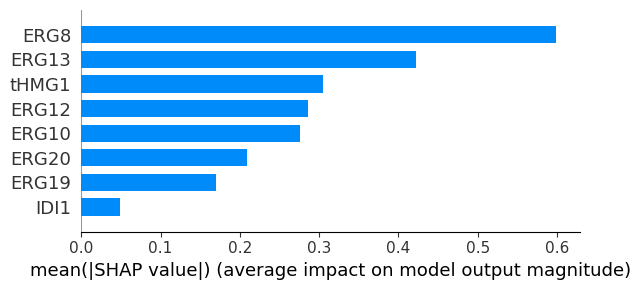

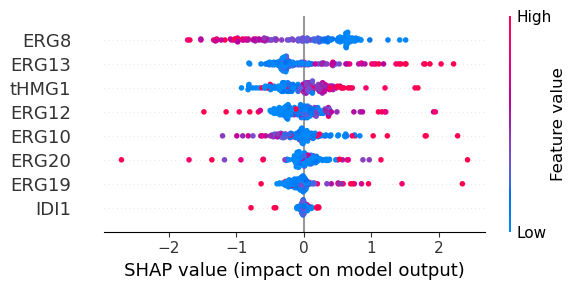

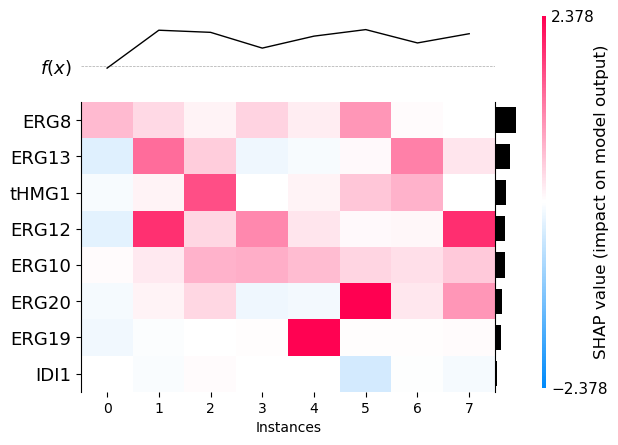

In [5]:
import shap

def pdplot(X: np.array, col: str, model: object, ice: bool=False):
    shap.plots.partial_dependence(col, model.predict, X, ice=ice, model_expected_value=True, feature_expected_value=True, show=True)
    
def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])

explainer = shap.Explainer(final_model.predict, train[INPUT_VARS])
shap_values = explainer(train[INPUT_VARS])
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

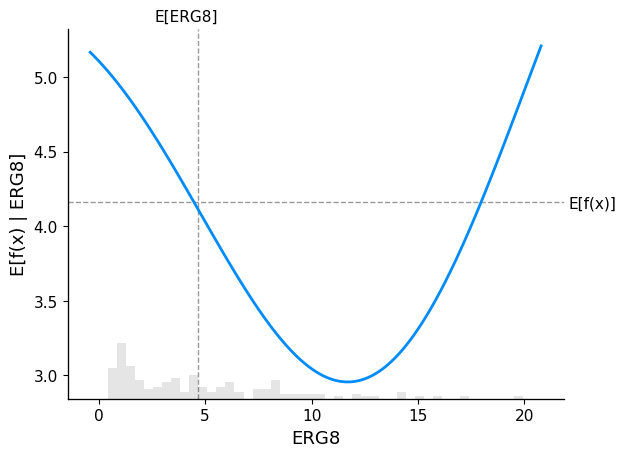

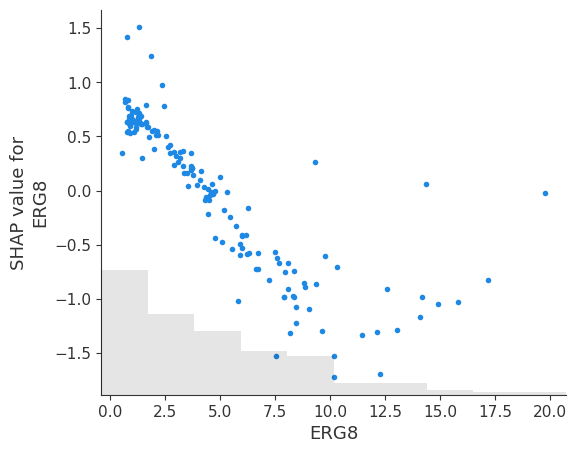

In [6]:
feature = 'ERG8'
pdplot(train[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

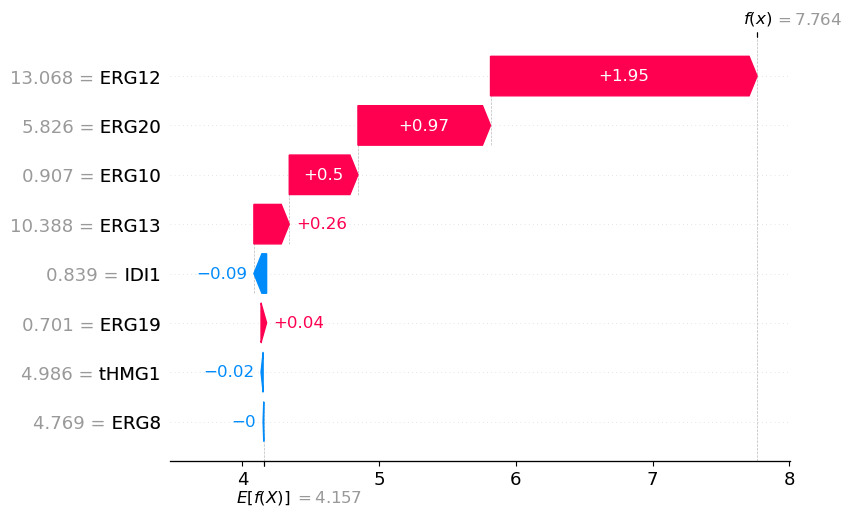

In [7]:
idx=2
shap.plots.waterfall(shap_values[idx])

#### Sampling

In [10]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds['ERG8'].loc['min'] = 13
sampling_bounds['ERG8'].loc['max'] = bounds['ERG8'].loc['max']

sampling_bounds['ERG10'].loc['min'] = 1.75
sampling_bounds['ERG10'].loc['max'] = bounds['ERG10'].loc['max']

sampling_bounds['ERG12'].loc['min'] = bounds['ERG12'].loc['min']
sampling_bounds['ERG12'].loc['max'] = 1.0

sampling_bounds['ERG13'].loc['min'] = bounds['ERG13'].loc['min']
sampling_bounds['ERG13'].loc['max'] = 1.0

sampling_bounds['ERG19'].loc['min'] = bounds['ERG19'].loc['min']
sampling_bounds['ERG19'].loc['max'] = 0.7

sampling_bounds['ERG20'].loc['min'] = 3.0
sampling_bounds['ERG20'].loc['max'] = bounds['ERG20'].loc['max']

sampling_bounds['IDI1'].loc['min'] = bounds['IDI1'].loc['min']
sampling_bounds['IDI1'].loc['max'] = 0.6

sampling_bounds['tHMG1'].loc['min'] = 1
sampling_bounds['tHMG1'].loc['max'] = bounds['tHMG1'].loc['max']


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T['min'].values.tolist()
UB = sampling_bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
69,13.443017,3.729317,0.649004,0.896023,0.617275,21.558745,0.428114,11.296729,4.607320
83,14.275451,20.881726,0.687642,0.237347,0.177201,5.540656,0.125976,1.802437,4.013810
50,21.160044,2.755345,0.392058,0.715138,0.281505,3.772695,0.177144,9.987706,3.951721
81,20.088055,2.154895,0.824458,0.861921,0.321702,3.313163,0.286296,4.465371,3.866536
64,21.291763,16.516024,0.338025,0.900743,0.307612,22.151088,0.495002,11.615557,3.852705
35,21.237096,18.007122,0.261177,0.316354,0.258074,21.761840,0.556041,11.201272,3.808671
22,20.584524,5.441181,0.036249,0.175160,0.449262,21.973797,0.074966,9.048494,3.805089
21,19.145214,15.366334,0.849510,0.630844,0.122031,7.432007,0.311421,2.001043,3.432052
12,19.885296,7.277192,0.790546,0.607457,0.194606,17.924534,0.542085,11.555897,3.420752
84,21.591023,4.847037,0.508953,0.002489,0.346880,6.568743,0.491798,11.115320,3.343170


# PCA

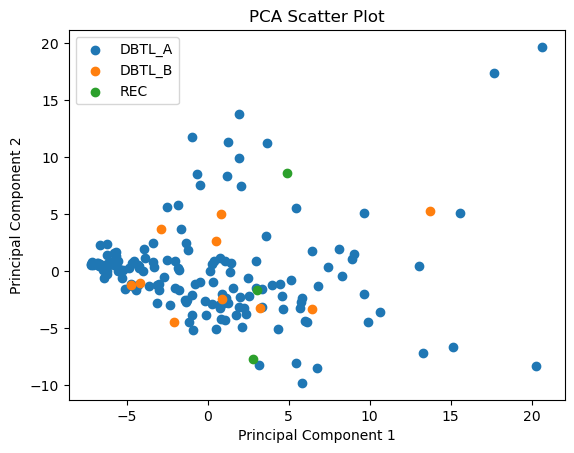

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
trans_df_A = pca.transform(X_train)
trans_df_B = pca.transform(X_test)
trans_rec  = pca.transform(sample_df[INPUT_VARS][:3])

# Plot
plt.scatter(trans_df_A[:,0], trans_df_A[:,1], label='DBTL_A')
plt.scatter(trans_df_B[:,0], trans_df_B[:,1], label='DBTL_B')
plt.scatter(trans_rec[:,0], trans_rec[:,1], label='REC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()